#### Base Settings

##### Library

In [1]:
# Library import

## pandas
import pandas as pd

import gdown
import zipfile as zf
from tqdm import tqdm
import nltk

import os
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import string
from collections import Counter
import random

# shikit learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow as keras
from keras import layers, Input, Sequential, Model
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D, \
                                    TextVectorization
import tensorflow_datasets as tfds

##### Parmas

In [26]:
RAND_SEED = 83
random.seed(RAND_SEED)

NUM_TEXT_DATA       = 15000         #📌 훈련 데이터 개수
MAX_LENGTH          = 20            #📌 문장 길이
BATCH_SIZE          = 64
BUFFER_SIZE         = 20000
NUM_LAYERS          = 1
D_MODEL             = 256
NUM_HEADS           = 8
DFF                 = 512
DROPOUT             = 0.2
VOCAB_SIZE          = 10000

### Data handling

In [3]:
def collect_json_file(path):
    """
    폴더의 json파일을 모두 불러와 리스트로 반환하는 함수
    """
    file_list = os.listdir(path)

    json_list = []
    for file_name in file_list:
        if '.json' in file_name:
            json_list.append(file_name)

    return json_list

In [4]:
def parsing_corpus(js):
    Q1_list = [js[x]["talk"]["content"]["HS01"] for x in range(len(js))]
    Q2_list = [js[x]["talk"]["content"]["HS02"] for x in range(len(js))]
    Q3_list = [js[x]["talk"]["content"]["HS03"] for x in range(len(js))]
    A1_list = [js[x]["talk"]["content"]["SS01"] for x in range(len(js))]
    A2_list = [js[x]["talk"]["content"]["SS02"] for x in range(len(js))]
    A3_list = [js[x]["talk"]["content"]["SS03"] for x in range(len(js))]

    df_qa = pd.DataFrame({"Q1":Q1_list,"A1":A1_list,"Q2":Q2_list,"A2":A2_list,"Q3":Q3_list,"A3":A3_list})

    return df_qa

#### 감성 대화 말뭉치

- [감성 대화 말뭉치](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86)



2020년/10,000문장 (음성), 27만문장 (코퍼스)



In [5]:
# 데이터파일(.json) 불러와서 폴더에 저장

## 데이터파일 불러올 URL
url_list = ["https://drive.google.com/file/d/1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg/view?usp=sharing",
            "https://drive.google.com/file/d/1lwHywo0OIItRgOv-nK_M_tlxTD_HhG-c/view?usp=sharing"]

# url_list = ["https://drive.google.com/file/d/1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg/view?usp=sharing"]

for idx, val in enumerate(url_list):
    data_url = val
    file_name = "donwload.zip"
    unzip_path = "data/emotion/"

    # 구글드라이브에서 다운로드
    file_id = "https://drive.google.com/uc?id=" + data_url.split('/')[-2]
    gdown.download(file_id, file_name)

    # 압축풀기
    files = zf.ZipFile(file_name)
    files.extractall(unzip_path)
    files.close()

# 데이터파일(.json)
json_list = collect_json_file(unzip_path)
print(f"\n데이터파일 개수 : {len(json_list)}개")

Downloading...
From: https://drive.google.com/uc?id=1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg
To: /content/donwload.zip
100%|██████████| 8.30M/8.30M [00:00<00:00, 16.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lwHywo0OIItRgOv-nK_M_tlxTD_HhG-c
To: /content/donwload.zip
100%|██████████| 993k/993k [00:00<00:00, 44.6MB/s]



데이터파일 개수 : 2개


In [6]:
with tqdm(total=len(json_list)) as pbar:
    df_concat = pd.DataFrame()
    for idx, val in enumerate(json_list):
        with open(unzip_path+json_list[idx]) as f:
            js = json.loads(f.read())
            df_qa = parsing_corpus(js)
            df_concat = pd.concat([df_concat,df_qa])
        pbar.update()

print(f"\n데이터파일의 크기(shape) : {df_concat.shape}")

100%|██████████| 2/2 [00:06<00:00,  3.17s/it]


데이터파일의 크기(shape) : (58268, 6)


In [7]:
# 1턴만 사용
df = df_concat[["Q1","A1"]].copy()
print(df.shape)
df.sample(8, random_state=RAND_SEED)

(58268, 2)


,Q1,A1
9623,회사에서 갑자기 명예퇴직을 하라고 하네?,회사에서 명예 퇴직을 요구해서 많이 당황하셨겠어요.
46025,부모님이 내 감기에 대해 너무 걱정하셔서 죄송한 마음이 들어.,부모님께서 건강을 너무 걱정하셔서 죄송한 마음이 드시는군요.
16808,아내가 갑자기 암에 걸리는 바람에 나는 경제적으로 부담스럽고 책임져야 할 게 많아 ...,아내가 암에 걸리고 경제적으로도 어려운 상황이군요.
28751,오늘 내 동생이 결혼했어.,동생이 결혼하니 어떤 생각이 들던가요?
34405,요즘 이런저런 생각 때문에 힘들어.,무슨 일 때문에 그런 생각을 하시게 되었을까요?
1237,여자친구가 친구 애인과 나를 비교하니까 기분이 아주 나빠.,사용자님을 여자친구의 친구 애인들과 비교해서 기분이 나쁘시겠어요.
23212,부하 직원에게 싫은 소리를 못해서 내 마음을 몰라주는 직원들이 싫고 외로워.,직원들이 마음을 몰라줘서 직원들이 싫고 외로우시군요.
6777,남편이 주말까지 또 골프 하러 간대. 짜증 나네.,주말에 남편이 골프를 하러 가시는군요.


In [8]:
# NUM_TEXT_DATA       = NUM_TEXT_DATA       # ✅ 사용 할 데이터 개수
NUM_TEXT_DATA       = df.shape[0]       # ✅ 사용 할 데이터 개수

qna_data = df.sample(NUM_TEXT_DATA, random_state=RAND_SEED).copy()
print(qna_data.shape)
qna_data.head(8)

(58268, 2)


,Q1,A1
9623,회사에서 갑자기 명예퇴직을 하라고 하네?,회사에서 명예 퇴직을 요구해서 많이 당황하셨겠어요.
46025,부모님이 내 감기에 대해 너무 걱정하셔서 죄송한 마음이 들어.,부모님께서 건강을 너무 걱정하셔서 죄송한 마음이 드시는군요.
16808,아내가 갑자기 암에 걸리는 바람에 나는 경제적으로 부담스럽고 책임져야 할 게 많아 ...,아내가 암에 걸리고 경제적으로도 어려운 상황이군요.
28751,오늘 내 동생이 결혼했어.,동생이 결혼하니 어떤 생각이 들던가요?
34405,요즘 이런저런 생각 때문에 힘들어.,무슨 일 때문에 그런 생각을 하시게 되었을까요?
1237,여자친구가 친구 애인과 나를 비교하니까 기분이 아주 나빠.,사용자님을 여자친구의 친구 애인들과 비교해서 기분이 나쁘시겠어요.
23212,부하 직원에게 싫은 소리를 못해서 내 마음을 몰라주는 직원들이 싫고 외로워.,직원들이 마음을 몰라줘서 직원들이 싫고 외로우시군요.
6777,남편이 주말까지 또 골프 하러 간대. 짜증 나네.,주말에 남편이 골프를 하러 가시는군요.


#### 데이터 분할

In [9]:
qna_data = qna_data.sample(frac=1, random_state=RAND_SEED).reset_index(drop=True)   # 데이터 섞기
num_val_samples = int(0.2 * len(qna_data))                                          # 총 데이터의 20%
num_train_samples = len(qna_data) - num_val_samples                                 # train, val 비율 = 8:2
train_data = qna_data[:num_train_samples]
val_data = qna_data[num_train_samples :]

print(f"전체 데이터셋 개수: {len(qna_data)}")
print(f"학습 데이터셋 개수: {len(train_data)}")
print(f"검증 데이터셋 개수: {len(val_data)}")

전체 데이터셋 개수: 58268
학습 데이터셋 개수: 46615
검증 데이터셋 개수: 11653


In [10]:
q_train, a_train = list(train_data["Q1"]), list(train_data["A1"])
q_val, a_val = list(val_data["Q1"]), list(val_data["A1"])

q_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_train]
a_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_train]
q_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_val]
a_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_val]

print(f"{len(q_train)}, {len(a_train)}, {len(q_val)}, {len(a_val)}")

46615, 46615, 11653, 11653


In [11]:
for i in range(5):
    print(f"{'-'*50}\n질문 : {q_train[i]}\n답변 : {a_train[i]}")

--------------------------------------------------
질문 : 요새 젊은 친구들과 대화하는 방법을 모르겠어 .  점점 말을 걸기가 어려워 .
답변 : 젊은 친구들과의 대화가 어려우시군요 .
--------------------------------------------------
질문 : 혼자 병을 치료하겠다고 시골에서 혼자 살게 된지 삼 년이 훌쩍 지났는데 여전히 외롭고 쓸쓸해 .
답변 : 외롭고 쓸쓸한 마음 때문에 힘드시군요 .
--------------------------------------------------
질문 : 요즘 남편이 항상 나를 무시해서 화가나 .
답변 : 남편 분이 무시하셔서 화가 난 상황이시군요 .  앞으로 어떻게 행동하면 좋을까요 ?
--------------------------------------------------
질문 : 아빠가 맛있는 별식이라며 메뚜기를 볶아주셨는데 그게 너무 혐오스러웠어 .
답변 : 아빠의 별식이 혐오스러운 느낌을 주었군요 .
--------------------------------------------------
질문 : 노후 준비를 할 돈이 없다는 게 이해가 안 가 .  너무 짜증이 난다 .
답변 : 돈이 없어서 무언가를 못 하면 정말 답답하고 짜증이 나시겠어요 .


#### 벡터화

In [14]:
%%time
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    q_train + a_train + q_val + a_val
    , target_vocab_size=10000)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2 # ✅ 단어집합 크기

CPU times: user 1min 9s, sys: 592 ms, total: 1min 9s
Wall time: 1min 18s


In [18]:
print('시작 토큰 번호 :',START_TOKEN[0])
print('종료 토큰 번호 :',END_TOKEN[0])
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : 9978
종료 토큰 번호 : 9979
단어 집합의 크기 : 9980


In [15]:
print('Tokenized sample question: {}'.format(tokenizer.encode(q_train[0])))

Tokenized sample question: [451, 944, 259, 6223, 5856, 139, 2, 281, 87, 973, 338, 583, 1]


In [16]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_string = q_train[0]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [451, 944, 259, 6223, 5856, 139, 2, 281, 87, 973, 338, 583, 1]
기존 문장: 요새 젊은 친구들과 대화하는 방법을 모르겠어 .  점점 말을 걸기가 어려워 .


In [17]:
def prepare_batch(q_list, a_list):
    
    
    with tqdm(total=len(q_list)) as pbar:

        q_toked, a_toked_input, a_toked_label = [], [], []
        for (q_text, a_text) in zip(q_list, a_list):
            # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
            q_input = START_TOKEN + tokenizer.encode(q_text) + END_TOKEN
            a_input = START_TOKEN + tokenizer.encode(a_text)
            a_label = tokenizer.encode(a_text) + END_TOKEN

            q_toked.append(q_input)
            a_toked_input.append(a_input)
            a_toked_label.append(a_label)
            
            pbar.update()

        # # 패딩
        q_toked = tf.keras.preprocessing.sequence.pad_sequences(
                        q_toked, maxlen=MAX_LENGTH, padding='post')
        a_toked_input = tf.keras.preprocessing.sequence.pad_sequences(
                        a_toked_input, maxlen=MAX_LENGTH, padding='post')
        a_toked_label = tf.keras.preprocessing.sequence.pad_sequences(
                        a_toked_label, maxlen=MAX_LENGTH, padding='post')

    return q_toked, a_toked_input, a_toked_label

In [20]:
q_toked_train, a_toked_input_train, a_toked_label_train = prepare_batch(q_train, a_train)
q_toked_val, a_toked_input_val, a_toked_label_val = prepare_batch(q_val, a_val)

100%|██████████| 11653/11653 [00:01<00:00, 7239.00it/s]


In [21]:
print('질문 데이터의 크기(shape) :', q_toked_train.shape)
print('답변(input) 데이터의 크기(shape) :', a_toked_input_train.shape)
print('답변(label) 데이터의 크기(shape) :', a_toked_label_train.shape)

질문 데이터의 크기(shape) : (46615, 20)
답변(input) 데이터의 크기(shape) : (46615, 20)
답변(label) 데이터의 크기(shape) : (46615, 20)


#### 데이터를 모델에 넣을 수 있도록 구성

In [22]:
# Train Batch
train_batches = tf.data.Dataset.from_tensor_slices(((q_toked_train, a_toked_input_train),a_toked_label_train))

train_batches = train_batches.cache()
train_batches = train_batches.shuffle(BUFFER_SIZE)
train_batches = train_batches.batch(BATCH_SIZE)
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# Validation Batch
val_batches = tf.data.Dataset.from_tensor_slices(((q_toked_val, a_toked_input_val),a_toked_label_val))

val_batches = val_batches.cache()
val_batches = val_batches.shuffle(BUFFER_SIZE)
val_batches = val_batches.batch(BATCH_SIZE)
val_batches = val_batches.prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
for (pt, en), en_labels in train_batches.take(1):
    pt = pt
    en = en
    en_labels = en_labels
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 20)
(64, 20)
(64, 20)


### Define the Components
- [Tensorflow : Translate text with Transformer Models](https://www.tensorflow.org/text/tutorials/transformer#the_embedding_and_positional_encoding_layer)

#### The embedding and positional encoding layer

In [24]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

(10000, 256)


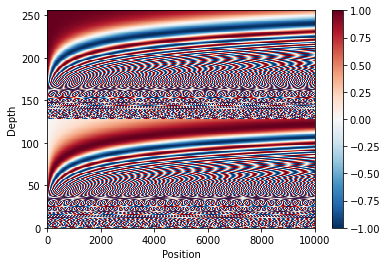

In [27]:
pos_encoding = positional_encoding(length=VOCAB_SIZE, depth=D_MODEL)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu_r')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

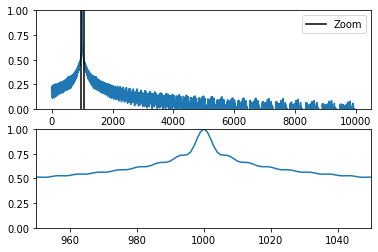

In [28]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])
plt.show()

In [29]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=vocab_size, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [31]:
embed_pt = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=D_MODEL)
embed_en = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=D_MODEL)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)
en_emb._keras_mask

<tf.Tensor: shape=(64, 20), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

#### The base attention layer

In [32]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [33]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [34]:
sample_ca = CrossAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 20, 256)
(64, 20, 256)
(64, 20, 256)


In [35]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [36]:
sample_gsa = GlobalSelfAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 20, 256)
(64, 20, 256)


In [37]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [38]:
sample_csa = CausalSelfAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 20, 256)
(64, 20, 256)


In [39]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

5.9604645e-07

In [40]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [41]:
sample_ffn = FeedForward(D_MODEL, DFF)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 20, 256)
(64, 20, 256)


#### The encoder layer

In [42]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [43]:
sample_encoder_layer = EncoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 20, 256)
(64, 20, 256)


In [44]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [45]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 20)
(64, 20, 256)


#### The decoder layer

In [46]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [47]:
sample_decoder_layer = DecoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 20, 256)
(64, 20, 256)
(64, 20, 256)


In [48]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [49]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 20)
(64, 20, 256)
(64, 20, 256)


#### The Transformer

In [50]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [51]:
transformer = Transformer(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_vocab_size=VOCAB_SIZE,
    target_vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT)

In [52]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 20)
(64, 20)
(64, 20, 10000)


In [53]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 20, 20)


In [54]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  9662464   
                                                                 
 decoder_1 (Decoder)         multiple                  15974656  
                                                                 
 dense_30 (Dense)            multiple                  2570000   
                                                                 
Total params: 28,207,120
Trainable params: 28,207,120
Non-trainable params: 0
_________________________________________________________________


### Training

#### Set up the optimizer

In [55]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [56]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

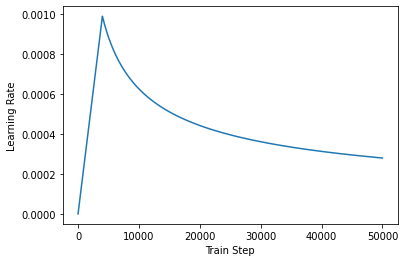

In [60]:
plt.plot(learning_rate(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [61]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

#### Train the model

In [62]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [65]:
%%time
t_tistory = transformer.fit(train_batches,
                epochs=2,
                validation_data=val_batches)

Epoch 1/2
 98/729 [===>..........................] - ETA: 52:52 - loss: 8.8928 - masked_accuracy: 0.0738

KeyboardInterrupt: ignored

In [66]:
plt.plot(t_tistory.history["loss"], label="Training Loss")
plt.plot(t_tistory.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

NameError: ignored

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = transformer(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

### Test Chat

In [ ]:
%%time
output = predict('오늘 날씨 어때?')

In [ ]:
%%time
output = predict('위로봇이 멍청해서 속상해')

In [ ]:
%%time
output = predict('친구가 괴롭혀서 힘들어')

In [ ]:
%%time
output = predict('선물을 받아서 기뻐')